In [1]:
from nn_data_loader_utils import *
from nn_train_utils import overfit_train_data
from nn_model_utils import MultilayerPerceptron
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.metrics import *
# Import the model we are using
from sklearn.ensemble import RandomForestRegressor

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

# Extra pre processing

In [15]:
df = pd.read_pickle('../data/yelp_data_no_na.pkl')

In [16]:
unique_values = {}
for col in df.columns:
    unique_values[col] = len(set(df[col]))

In [17]:
for key in sorted(unique_values, key=unique_values.get, reverse=False):
    print(key, unique_values[key])

BusinessParking 1
Music_no_music 1
Ambience 1
Music 1
GoodForMeal 1
DietaryRestrictions_kosher 1
DietaryRestrictions_soy-free 1
BestNights 1
HairSpecializesIn 1
DietaryRestrictions 1
label 2
is_open 2
RestaurantsGoodForGroups 2
GoodForKids 2
RestaurantsReservations 2
Caters 2
HasTV 2
BikeParking 2
RestaurantsDelivery 2
OutdoorSeating 2
RestaurantsTakeOut 2
GoodForMeal_dessert 2
GoodForMeal_latenight 2
GoodForMeal_lunch 2
GoodForMeal_dinner 2
GoodForMeal_brunch 2
GoodForMeal_breakfast 2
BusinessParking_garage 2
BusinessParking_street 2
BusinessParking_validated 2
BusinessParking_lot 2
BusinessParking_valet 2
Ambience_romantic 2
Ambience_intimate 2
Ambience_classy 2
Ambience_hipster 2
Ambience_divey 2
Ambience_touristy 2
Ambience_trendy 2
Ambience_upscale 2
Ambience_casual 2
BusinessAcceptsCreditCards 2
GoodForDancing 2
HappyHour 2
ByAppointmentOnly 2
WheelchairAccessible 2
HairSpecializesIn_straightperms 2
HairSpecializesIn_coloring 2
HairSpecializesIn_extensions 2
HairSpecializesIn_afr

In [73]:
df_train = pd.read_pickle('../data/train.pkl')
df_val = pd.read_pickle('../data/val.pkl')
df_test = pd.read_pickle('../data/test.pkl')

# Remove Single Value features

In [74]:
column_to_remove = []
for col in df_train.columns:
    if unique_values.get(col, -1) == 1:
        column_to_remove.append(col)

In [75]:
column_to_remove

['BusinessParking',
 'Music_no_music',
 'Ambience',
 'Music',
 'GoodForMeal',
 'DietaryRestrictions_kosher',
 'DietaryRestrictions_soy-free',
 'BestNights',
 'HairSpecializesIn',
 'DietaryRestrictions']

In [76]:
df_train.drop(column_to_remove, axis=1, inplace=True)
df_val.drop(column_to_remove, axis=1, inplace=True)
df_test.drop(column_to_remove, axis=1, inplace=True)

# Format Categorical into Dummy features

In [77]:
cat_to_num_mapping = {'AcceptsInsurance': {np.nan: np.nan, 'True': 1, 'False': 0, 'None': 0},
                      'AgesAllowed': {np.nan: np.nan, 'None': 0, '18plus': 1, '19plus': 2, '21plus': 3, 'allages': 4},
                      'Alcohol': {np.nan: np.nan, 'None': 0, 'none': 0, 'full_bar': 1, 'beer_and_wine': 2},
                      'Ambience': {np.nan: np.nan, 'None': 0},
                      'Ambience_casual': {np.nan: np.nan, 'True': 1, 'False': 0},
                      'Ambience_classy': {np.nan: np.nan, 'False': 0, 'True': 1},
                      'Ambience_divey': {np.nan: np.nan, 'False': 0, 'True': 1},
                      'Ambience_hipster': {np.nan: np.nan, 'False': 0, 'True': 1},
                      'Ambience_intimate': {np.nan: np.nan, 'False': 0, 'True': 1},
                      'Ambience_romantic': {np.nan: np.nan, 'False': 0, 'True': 1},
                      'Ambience_touristy': {np.nan: np.nan, 'False': 0, 'True': 1},
                      'Ambience_trendy': {np.nan: np.nan, 'False': 0, 'True': 1},
                      'Ambience_upscale': {np.nan: np.nan, 'False': 0, 'True': 1},
                      'BestNights': {np.nan: np.nan, 'None': 0},
                      'BestNights_friday': {np.nan: np.nan, 'True': 1, 'False': 0},
                      'BestNights_monday': {np.nan: np.nan, 'False': 0, 'True': 1},
                      'BestNights_saturday': {np.nan: np.nan, 'True': 1, 'False': 0},
                      'BestNights_sunday': {np.nan: np.nan, 'False': 0, 'True': 1},
                      'BestNights_thursday': {np.nan: np.nan, 'False': 0, 'True': 1},
                      'BestNights_tuesday': {np.nan: np.nan, 'False': 0, 'True': 1},
                      'BestNights_wednesday': {np.nan: np.nan, 'True': 1, 'False': 0},
                      'BikeParking': {np.nan: np.nan, 'False': 0, 'None': 0, 'True': 1},
                      'BusinessAcceptsBitcoin': {np.nan: np.nan, 'False': 0, 'None': 0, 'True': 1},
                      'BusinessAcceptsCreditCards': {'True': 1, np.nan: np.nan, 'False': 0, 'None': 0},
                      'BusinessParking': {np.nan: np.nan, '{}': 0, 'None': 0},
                      'BusinessParking_garage': {'True': 1, 'False': 0, np.nan: np.nan},
                      'BusinessParking_lot': {'True': 1, 'False': 0, np.nan: np.nan},
                      'BusinessParking_street': {'True': 1, 'False': 0, np.nan: np.nan},
                      'BusinessParking_valet': {'True': 1, 'False': 0, np.nan: np.nan},
                      'BusinessParking_validated': {np.nan: np.nan, 'False': 0, 'True': 1},
                      'ByAppointmentOnly': {'True': 1, np.nan: np.nan, 'False': 0, 'None': 0},
                      'BYOB': {np.nan: np.nan, 'False': 0, 'True': 1},
                      'BYOBCorkage': {np.nan: np.nan, 'yes_free': 1, 'None': 0, 'yes_corkage': 1, 'no': 0},
                      'Caters': {np.nan: np.nan, 'False': 0, 'None': 0, 'True': 1},
                      'CoatCheck': {np.nan: np.nan, 'False': 0, 'None': 0, 'True': 1},
                      'Corkage': {np.nan: np.nan, 'False': 0, 'True': 1},
                      'DietaryRestrictions': {np.nan: np.nan, 'None': 0},
                      'DietaryRestrictions_dairy-free': {np.nan: np.nan, 'False': 0, 'True': 1},
                      'DietaryRestrictions_gluten-free': {np.nan: np.nan, 'True': 1, 'False': 0},
                      'DietaryRestrictions_halal': {np.nan: np.nan, 'False': 0, 'True': 1},
                      'DietaryRestrictions_kosher': {np.nan: np.nan, 'False': 0},
                      'DietaryRestrictions_soy-free': {np.nan: np.nan, 'False': 0},
                      'DietaryRestrictions_vegan': {np.nan: np.nan, 'False': 0, 'True': 1},
                      'DietaryRestrictions_vegetarian': {np.nan: np.nan, 'False': 0, 'True': 1},
                      'DogsAllowed': {np.nan: np.nan, 'False': 0, 'None': 0, 'True': 1},
                      'DriveThru': {np.nan: np.nan, 'False': 0, 'None': 0, 'True': 1},
                      'GoodForDancing': {np.nan: np.nan, 'False': 0, 'None': 0, 'True': 1},
                      'GoodForKids': {np.nan: np.nan, 'True': 1, 'False': 0, 'None': 0},
                      'GoodForMeal': {np.nan: np.nan, '{}': 0, 'None': 0},
                      'GoodForMeal_breakfast': {np.nan: np.nan, 'False': 0, 'True': 1},
                      'GoodForMeal_brunch': {np.nan: np.nan, 'False': 0, 'True': 1},
                      'GoodForMeal_dessert': {np.nan: np.nan, 'False': 0, 'True': 1},
                      'GoodForMeal_dinner': {np.nan: np.nan, 'True': 1, 'False': 0},
                      'GoodForMeal_latenight': {np.nan: np.nan, 'False': 0, 'True': 1},
                      'GoodForMeal_lunch': {np.nan: np.nan, 'True': 1, 'False': 0},
                      'HairSpecializesIn': {np.nan: np.nan, 'None': 0},
                      'HairSpecializesIn_africanamerican': {np.nan: np.nan, 'False': 0, 'True': 1},
                      'HairSpecializesIn_asian': {np.nan: np.nan, 'False': 0, 'True': 1},
                      'HairSpecializesIn_coloring': {np.nan: np.nan, 'True': 1, 'False': 0},
                      'HairSpecializesIn_curly': {np.nan: np.nan, 'True': 1, 'False': 0},
                      'HairSpecializesIn_extensions': {np.nan: np.nan, 'True': 1, 'False': 0},
                      'HairSpecializesIn_kids': {np.nan: np.nan, 'False': 0, 'True': 1},
                      'HairSpecializesIn_perms': {np.nan: np.nan, 'False': 0, 'True': 1},
                      'HairSpecializesIn_straightperms': {np.nan: np.nan, 'False': 0, 'True': 1},
                      'HappyHour': {np.nan: np.nan, 'True': 1, 'False': 0, 'None': 0},
                      'HasTV': {np.nan: np.nan, 'False': 0, 'None': 0, 'True': 1},
                      'Music': {np.nan: np.nan, '{}': 0, 'None': 0},
                      'Music_background_music': {np.nan: np.nan, 'False': 0, 'True': 1},
                      'Music_dj': {np.nan: np.nan, 'False': 0, 'True': 1},
                      'Music_jukebox': {np.nan: np.nan, 'False': 0, 'True': 1},
                      'Music_karaoke': {np.nan: np.nan, 'True': 1, 'False': 0},
                      'Music_live': {np.nan: np.nan, 'False': 0, 'True': 1},
                      'Music_no_music': {np.nan: np.nan, 'False': 0},
                      'Music_video': {np.nan: np.nan, 'False': 0, 'True': 1},
                      'NoiseLevel': {np.nan: np.nan, 'None': 0, 'quiet': 1, 'average': 2, 'loud': 3, 'very_loud': 4},
                      'Open24Hours': {np.nan: np.nan, 'True': 1, 'False': 0},
                      'OutdoorSeating': {np.nan: np.nan, 'False': 0, 'None': 0, 'True': 1},
                      'RestaurantsAttire': {np.nan: np.nan, 'None': 0, 'casual': 1, 'dressy': 2, 'formal': 3},
                      'RestaurantsCounterService': {np.nan: np.nan, 'False': 0, 'True': 1},
                      'RestaurantsDelivery': {np.nan: np.nan, 'False': 0, 'None': 0, 'True': 1},
                      'RestaurantsGoodForGroups': {np.nan: np.nan, 'True': 1, 'False': 0, 'None': 0},
                      'RestaurantsPriceRange2': {np.nan: np.nan, '1': 1, 'None': 0, '2': 2, '3': 3, '4': 4},
                      'RestaurantsReservations': {np.nan: np.nan, 'False': 0, 'None': 0, 'True': 1},
                      'RestaurantsTableService': {np.nan: np.nan, 'True': 1, 'False': 0, 'None': 0, 'none': 0},
                      'RestaurantsTakeOut': {np.nan: np.nan, 'True': 1, 'False': 0, 'None': 0},
                      'Smoking': {np.nan: np.nan, 'None': 0, 'outdoor': 2, 'yes': 1, 'no': 0},
                      'WheelchairAccessible': {np.nan: np.nan, 'True': 1, 'False': 0, 'None': 0},
                      'WiFi': {np.nan: np.nan, 'paid': 2, 'None': 0, 'free': 1, 'no': 0}
                      }


In [78]:
reverse_cat_to_num_mapping = {col: {cat_to_num_mapping[col][key]: key for key in cat_to_num_mapping[col]} for col in cat_to_num_mapping}

In [79]:
reverse_cat_to_num_mapping

{'AcceptsInsurance': {nan: nan, 1: 'True', 0: 'None'},
 'AgesAllowed': {nan: nan,
  0: 'None',
  1: '18plus',
  2: '19plus',
  3: '21plus',
  4: 'allages'},
 'Alcohol': {nan: nan, 0: 'none', 1: 'full_bar', 2: 'beer_and_wine'},
 'Ambience': {nan: nan, 0: 'None'},
 'Ambience_casual': {nan: nan, 1: 'True', 0: 'False'},
 'Ambience_classy': {nan: nan, 0: 'False', 1: 'True'},
 'Ambience_divey': {nan: nan, 0: 'False', 1: 'True'},
 'Ambience_hipster': {nan: nan, 0: 'False', 1: 'True'},
 'Ambience_intimate': {nan: nan, 0: 'False', 1: 'True'},
 'Ambience_romantic': {nan: nan, 0: 'False', 1: 'True'},
 'Ambience_touristy': {nan: nan, 0: 'False', 1: 'True'},
 'Ambience_trendy': {nan: nan, 0: 'False', 1: 'True'},
 'Ambience_upscale': {nan: nan, 0: 'False', 1: 'True'},
 'BestNights': {nan: nan, 0: 'None'},
 'BestNights_friday': {nan: nan, 1: 'True', 0: 'False'},
 'BestNights_monday': {nan: nan, 0: 'False', 1: 'True'},
 'BestNights_saturday': {nan: nan, 1: 'True', 0: 'False'},
 'BestNights_sunday': {n

In [80]:
list_unique_values = {}
column_to_format = []
for col in df.columns:
    if unique_values.get(col, -1) > 2 and unique_values.get(col, -1) < 9:
        list_unique_values[col] = set(df[col])
        column_to_format.append(col)

In [81]:
def format_column(column):
    formated_column = re.sub(r'[^a-zA-Z 0-9]', ' ', column.lower().strip())
    formated_column = re.sub(r'\s+', '_', column)
    return formated_column

In [82]:
for col in column_to_format:
    print(col)
    for value in list(list_unique_values[col]):
        col_name = '{}_{}'.format(col, format_column(reverse_cat_to_num_mapping[col][int(value)]))
        df_train[col_name] = df[col].apply(lambda x: int(x == value))
        df_val[col_name] = df[col].apply(lambda x: int(x == value))
        df_test[col_name] = df[col].apply(lambda x: int(x == value))

RestaurantsPriceRange2
RestaurantsAttire
Alcohol
NoiseLevel
WiFi
Smoking
AgesAllowed


In [84]:
col = 'Alcohol'
print(set(df_train[col].values))

{0.0, 1.0, 2.0}


In [85]:
for col in sorted(df_train.columns):
    print(col)

AcceptsInsurance
AgesAllowed
AgesAllowed_18plus
AgesAllowed_19plus
AgesAllowed_21plus
AgesAllowed_None
AgesAllowed_allages
Alcohol
Alcohol_beer_and_wine
Alcohol_full_bar
Alcohol_none
Ambience_casual
Ambience_classy
Ambience_divey
Ambience_hipster
Ambience_intimate
Ambience_romantic
Ambience_touristy
Ambience_trendy
Ambience_upscale
BYOB
BYOBCorkage
BestNights_friday
BestNights_monday
BestNights_saturday
BestNights_sunday
BestNights_thursday
BestNights_tuesday
BestNights_wednesday
BikeParking
BusinessAcceptsBitcoin
BusinessAcceptsCreditCards
BusinessParking_garage
BusinessParking_lot
BusinessParking_street
BusinessParking_valet
BusinessParking_validated
ByAppointmentOnly
Caters
CoatCheck
Corkage
DietaryRestrictions_dairy-free
DietaryRestrictions_gluten-free
DietaryRestrictions_halal
DietaryRestrictions_vegan
DietaryRestrictions_vegetarian
DogsAllowed
DriveThru
GoodForDancing
GoodForKids
GoodForMeal_breakfast
GoodForMeal_brunch
GoodForMeal_dessert
GoodForMeal_dinner
GoodForMeal_latenight

In [86]:
df_train.drop(column_to_format, axis=1, inplace=True)
df_val.drop(column_to_format, axis=1, inplace=True)
df_test.drop(column_to_format, axis=1, inplace=True)

# Scale other Features based on train values

In [89]:
df_train.drop(['group_categories'], axis=1, inplace=True)
df_val.drop(['group_categories'], axis=1, inplace=True)
df_test.drop(['group_categories'], axis=1, inplace=True)

In [90]:
min_max_columns = {}
for col in df_train.columns:
    if unique_values.get(col, -1) > 9:
        min_max_columns[col] = (np.min(df_train[col].values), np.max(df_train[col].values))

In [91]:
min_max_columns

{'average_stars': (1.0, 5.0),
 'compliment_cool': (0.0, 19348.0),
 'compliment_funny': (0.0, 19348.0),
 'compliment_note': (0.0, 7579.0),
 'compliment_plain': (0.0, 17595.0),
 'cool': (0.0, 148658.0),
 'fans': (0.0, 9538.0),
 'funny': (0.0, 130207.0),
 'user_review_count': (1.0, 13278.0),
 'useful': (0.0, 154202.0),
 'seniority': (411.0, 5557.0),
 'nb_friends': (1.0, 9564.0),
 'latitude': (33.2057187, 51.2965919),
 'longitude': (-115.4775185511, -72.94505),
 'business_review_count': (3.0, 6708.0)}

In [92]:
for col in min_max_columns:
    df_train[col] = df_train[col].apply(lambda x: (min_max_columns[col][1] - x) / (min_max_columns[col][1] - min_max_columns[col][0]))
    df_val[col] = df_val[col].apply(lambda x: (min_max_columns[col][1] - x) / (min_max_columns[col][1] - min_max_columns[col][0]))
    df_test[col] = df_test[col].apply(lambda x: (min_max_columns[col][1] - x) / (min_max_columns[col][1] - min_max_columns[col][0]))

In [95]:
for col in df_train:
    print('{} {:.2f} {:.2f}'.format(col, np.min(df_train[col].values), np.max(df_train[col].values)))

label 0.00 1.00
average_stars 0.00 1.00
compliment_cool 0.00 1.00
compliment_funny 0.00 1.00
compliment_note 0.00 1.00
compliment_plain 0.00 1.00
cool 0.00 1.00
fans 0.00 1.00
funny 0.00 1.00
user_review_count 0.00 1.00
useful 0.00 1.00
seniority 0.00 1.00
nb_friends 0.00 1.00
is_open 0.00 1.00
latitude 0.00 1.00
longitude 0.00 1.00
business_review_count 0.00 1.00
RestaurantsGoodForGroups 0.00 1.00
GoodForKids 0.00 1.00
RestaurantsReservations 0.00 1.00
Caters 0.00 1.00
HasTV 0.00 1.00
BikeParking 0.00 1.00
RestaurantsDelivery 0.00 1.00
OutdoorSeating 0.00 1.00
RestaurantsTakeOut 0.00 1.00
GoodForMeal_dessert 0.00 1.00
GoodForMeal_latenight 0.00 1.00
GoodForMeal_lunch 0.00 1.00
GoodForMeal_dinner 0.00 1.00
GoodForMeal_brunch 0.00 1.00
GoodForMeal_breakfast 0.00 1.00
BusinessParking_garage 0.00 1.00
BusinessParking_street 0.00 1.00
BusinessParking_validated 0.00 1.00
BusinessParking_lot 0.00 1.00
BusinessParking_valet 0.00 1.00
Ambience_romantic 0.00 1.00
Ambience_intimate 0.00 1.00
Amb

In [96]:
df_train.to_pickle("../data_nn/train.pkl")
df_val.to_pickle("../data_nn/val.pkl")
df_test.to_pickle("../data_nn/test.pkl")

# PCA 

In [2]:
df_train = pd.read_pickle('../data_nn/train.pkl')
df_val = pd.read_pickle('../data_nn/val.pkl')
df_test = pd.read_pickle('../data_nn/test.pkl')

In [3]:
df = pd.concat([df_train, df_val, df_test])

In [4]:
df.reset_index(drop=True, inplace=True)

In [5]:
df.head()

,label,average_stars,compliment_cool,compliment_funny,compliment_note,compliment_plain,cool,fans,funny,user_review_count,...,WiFi_free,WiFi_paid,Smoking_no,Smoking_yes,Smoking_outdoor,AgesAllowed_None,AgesAllowed_18plus,AgesAllowed_19plus,AgesAllowed_21plus,AgesAllowed_allages
0,0.0,0.5975,0.999793,0.999793,0.999076,0.999886,0.999664,0.999476,0.999263,0.971680,...,1,0,1,0,0,0,0,0,1,0
1,0.0,0.6600,0.999948,0.999948,0.999736,0.999943,0.999879,1.000000,0.999578,0.993975,...,1,0,1,0,0,0,0,0,1,0
2,0.0,0.6600,0.999948,0.999948,0.999736,0.999943,0.999879,1.000000,0.999578,0.993975,...,1,0,1,0,0,0,0,0,1,0
3,0.0,0.4200,0.995607,0.995607,0.991951,0.996419,0.996939,0.992766,0.996997,0.988175,...,1,0,1,0,0,0,0,0,1,0
4,0.0,0.3800,0.997571,0.997571,0.996306,0.998181,0.996307,0.991403,0.996521,0.942758,...,1,0,1,0,0,0,0,0,1,0


In [6]:
df_features = df.drop('label', axis=1)

In [7]:
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(np.array(df_features.values, dtype=np.double))
principalDf = pd.DataFrame(data = principalComponents, columns = ['PC_{}'.format(i+1) for i in range(2)])

In [8]:
finalDf = pd.concat([principalDf, df[['label']]], axis = 1)

In [9]:
finalDf.head()

,PC_1,PC_2,label
0,0.836714,0.375484,0.0
1,0.838002,0.379951,0.0
2,0.838002,0.379951,0.0
3,0.836194,0.374563,0.0
4,0.836799,0.376999,0.0


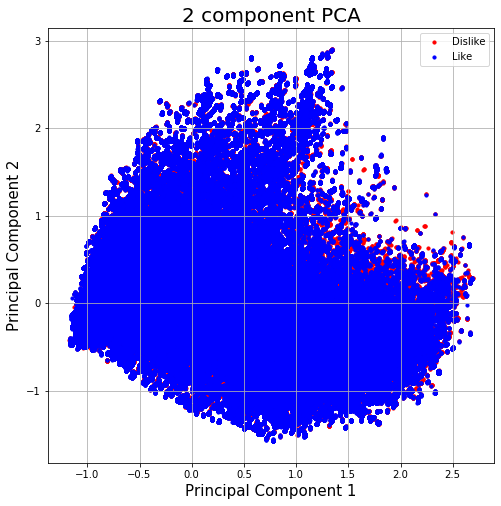

In [10]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = [0, 1]
colors = ['r', 'b']

for target, color in zip(targets, colors):
    indicesToKeep = finalDf['label'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'PC_1']
               , finalDf.loc[indicesToKeep, 'PC_2']
               , c = color
               , s = 10)
ax.legend(['Dislike', 'Like'])
ax.grid()

# PCA Transformation

In [11]:
df_train.reset_index(drop=True, inplace=True)
df_val.reset_index(drop=True, inplace=True)
df_test.reset_index(drop=True, inplace=True)

In [12]:
pca_num_features = 20

pca = PCA(n_components=pca_num_features)
pca_transformer = pca.fit(np.array(df_train.drop('label', axis=1).values, dtype=np.double))

In [13]:
pca_data = pca_transformer.transform(np.array(df_train.drop('label', axis=1).values, dtype=np.double))
df_pca_train = pd.DataFrame(data=pca_data,
                            columns = ['PC_{}'.format(i) for i in range(pca_num_features)])

In [14]:
pca_data = pca_transformer.transform(np.array(df_val.drop('label', axis=1).values, dtype=np.double))
df_pca_val = pd.DataFrame(data=pca_data,
                          columns = ['PC_{}'.format(i) for i in range(pca_num_features)])

In [15]:
pca_data = pca_transformer.transform(np.array(df_test.drop('label', axis=1).values, dtype=np.double))
df_pca_test = pd.DataFrame(data=pca_data,
                          columns = ['PC_{}'.format(i) for i in range(pca_num_features)])

In [16]:
df_pca_train = pd.concat([df_pca_train, df_train[['label']]], axis = 1)
df_pca_val = pd.concat([df_pca_val, df_val[['label']]], axis = 1)
df_pca_test = pd.concat([df_pca_test, df_test[['label']]], axis = 1)

In [17]:
df_pca_train.head()

,PC_0,PC_1,PC_2,PC_3,PC_4,PC_5,PC_6,PC_7,PC_8,PC_9,...,PC_11,PC_12,PC_13,PC_14,PC_15,PC_16,PC_17,PC_18,PC_19,label
0,0.818315,0.385278,-0.101887,0.434347,1.285818,-0.007836,1.333461,-0.331859,0.648330,0.481042,...,0.432397,-0.013590,0.536495,0.181491,-0.496359,0.112310,-0.076246,0.113285,0.111016,0.0
1,0.819635,0.389869,-0.102994,0.430133,1.285523,-0.008913,1.334873,-0.331747,0.649808,0.483713,...,0.433220,-0.016202,0.527491,0.196214,-0.497371,0.115295,-0.085544,0.109878,0.117312,0.0
2,0.819635,0.389869,-0.102994,0.430133,1.285523,-0.008913,1.334873,-0.331747,0.649808,0.483713,...,0.433220,-0.016202,0.527491,0.196214,-0.497371,0.115295,-0.085544,0.109878,0.117312,0.0
3,0.817769,0.384363,-0.101024,0.434379,1.288062,-0.008814,1.332119,-0.329410,0.649061,0.485574,...,0.433854,-0.011616,0.533509,0.174081,-0.499319,0.103855,-0.075873,0.108938,0.101989,0.0
4,0.818383,0.386872,-0.101317,0.431854,1.288779,-0.009920,1.332430,-0.328343,0.650220,0.489191,...,0.435030,-0.012384,0.526612,0.180155,-0.501149,0.102093,-0.081554,0.104804,0.102104,0.0


In [18]:
print(sum(df_val['label']))
print(sum(df_pca_val['label']))

139478.0
139478.0


In [19]:
df_pca_train.to_pickle("../data_pca/train.pkl")
df_pca_val.to_pickle("../data_pca/val.pkl")
df_pca_test.to_pickle("../data_pca/test.pkl")

In [20]:
df_pca_train.head()

,PC_0,PC_1,PC_2,PC_3,PC_4,PC_5,PC_6,PC_7,PC_8,PC_9,...,PC_11,PC_12,PC_13,PC_14,PC_15,PC_16,PC_17,PC_18,PC_19,label
0,0.818315,0.385278,-0.101887,0.434347,1.285818,-0.007836,1.333461,-0.331859,0.648330,0.481042,...,0.432397,-0.013590,0.536495,0.181491,-0.496359,0.112310,-0.076246,0.113285,0.111016,0.0
1,0.819635,0.389869,-0.102994,0.430133,1.285523,-0.008913,1.334873,-0.331747,0.649808,0.483713,...,0.433220,-0.016202,0.527491,0.196214,-0.497371,0.115295,-0.085544,0.109878,0.117312,0.0
2,0.819635,0.389869,-0.102994,0.430133,1.285523,-0.008913,1.334873,-0.331747,0.649808,0.483713,...,0.433220,-0.016202,0.527491,0.196214,-0.497371,0.115295,-0.085544,0.109878,0.117312,0.0
3,0.817769,0.384363,-0.101024,0.434379,1.288062,-0.008814,1.332119,-0.329410,0.649061,0.485574,...,0.433854,-0.011616,0.533509,0.174081,-0.499319,0.103855,-0.075873,0.108938,0.101989,0.0
4,0.818383,0.386872,-0.101317,0.431854,1.288779,-0.009920,1.332430,-0.328343,0.650220,0.489191,...,0.435030,-0.012384,0.526612,0.180155,-0.501149,0.102093,-0.081554,0.104804,0.102104,0.0


# Create Data Loader

In [2]:
data_folder = '../data_pca'
batch_size = 100

train_loader, val_loader, test_loader = load_data(data_folder=data_folder,
                                                  batch_size=batch_size,
                                                  overfit_train=False)

In [3]:
train_size_for_overfit = 500
overfit_train_loader, _, _ = load_data(data_folder=data_folder,
                                                   batch_size=10,
                                                   overfit_train=True, 
                                                   train_size_for_overfit=train_size_for_overfit)

In [4]:
for X, y in overfit_train_loader:
    print(X.shape, y.shape)
    nb_features = X.shape[1]
    break

torch.Size([10, 20]) torch.Size([10, 2])


In [5]:
nb_features

20

# Create Model

In [6]:
model = MultilayerPerceptron(input_size=nb_features,
                             hidden_layer=[*[20 for _ in range(20)], 10, 5],
                             output_size=2,
                             activation_name='ReLU')

# Test Model lerning power by overfitting

In [8]:
overfit_train_data(overfit_train_loader=overfit_train_loader,
                   model=model,
                   epochs=100,
                   learning_rate=5e-03, 
                   weight_decay=0.001,
                   max_patience=5, 
                   factor=0.03, 
                   threshold=1e-3,
                   use_gpu=False)

starting epoch 1. time passed: 0:00:00.000034
train loss: 0.7437
train AUC: 0.3688
train Accuracy: 0.5400

starting epoch 2. time passed: 0:00:00.347080
train loss: 0.7437
train AUC: 0.3695
train Accuracy: 0.5800

starting epoch 3. time passed: 0:00:00.680534
train loss: 0.7437
train AUC: 0.5739
train Accuracy: 0.6200

starting epoch 4. time passed: 0:00:01.019008
train loss: 0.7437
train AUC: 0.3728
train Accuracy: 0.5000

starting epoch 5. time passed: 0:00:01.358148
train loss: 0.7437
train AUC: 0.4229
train Accuracy: 0.4400

starting epoch 6. time passed: 0:00:01.682541
train loss: 0.7437
train AUC: 0.4050
train Accuracy: 0.6000

starting epoch 7. time passed: 0:00:02.003932
train loss: 0.7437
train AUC: 0.3696
train Accuracy: 0.5000

starting epoch 8. time passed: 0:00:02.326714
train loss: 0.7437
train AUC: 0.4928
train Accuracy: 0.5400

starting epoch 9. time passed: 0:00:02.657131
train loss: 0.7437
train AUC: 0.3818
train Accuracy: 0.4200

starting epoch 10. time passed: 0:00:

train loss: 0.7436
train AUC: 0.5000
train Accuracy: 0.5200

starting epoch 78. time passed: 0:00:24.511830
train loss: 0.7436
train AUC: 0.5000
train Accuracy: 0.4800

starting epoch 79. time passed: 0:00:24.832855
train loss: 0.7436
train AUC: 0.5000
train Accuracy: 0.6000

starting epoch 80. time passed: 0:00:25.145798
train loss: 0.7436
train AUC: 0.5000
train Accuracy: 0.5200

starting epoch 81. time passed: 0:00:25.461169
train loss: 0.7436
train AUC: 0.5000
train Accuracy: 0.4800

starting epoch 82. time passed: 0:00:25.775611
train loss: 0.7436
train AUC: 0.5000
train Accuracy: 0.6200

starting epoch 83. time passed: 0:00:26.083430
train loss: 0.7436
train AUC: 0.5000
train Accuracy: 0.5600

starting epoch 84. time passed: 0:00:26.384434
train loss: 0.7436
train AUC: 0.5000
train Accuracy: 0.5200

starting epoch 85. time passed: 0:00:26.698000
train loss: 0.7436
train AUC: 0.5000
train Accuracy: 0.6200

starting epoch 86. time passed: 0:00:26.998844
train loss: 0.7436
train AUC

In [2]:
df_train = pd.read_pickle('../data_nn/train.pkl')
df_val = pd.read_pickle('../data_nn/val.pkl')
df_test = pd.read_pickle('../data_nn/test.pkl')

In [3]:
train_features = np.array(df_train.drop('label', axis=1).values, dtype=np.double)
train_labels = np.array(df_train['label'], dtype=np.double)

val_features = np.array(df_val.drop('label', axis=1).values, dtype=np.double)
val_labels = np.array(df_val['label'], dtype=np.double)

In [10]:
rf = RandomForestRegressor(n_estimators = 100 , random_state = 42, max_depth=20, max_leaf_nodes=10)
rf.fit(train_features, train_labels)
predictions = rf.predict(val_features)

In [11]:
predictions = np.array(predictions > 0.5, dtype=int)

In [12]:
print('recall', recall_score(val_labels, predictions))
print('precision', precision_score(val_labels, predictions))
print('accurcy', accuracy_score(val_labels, predictions))
print('f1', f1_score(val_labels, predictions))

recall 0.4712786245859562
precision 0.7557515205169183
accurcy 0.6994941426207778
f1 0.5805391799695303


In [6]:
print(len(predictions))

316097


In [7]:
predictions

array([0.78464763, 0.97404362, 0.33944598, ..., 0.04849673, 0.97404362,
       0.97404362])